# How To Split The Data Effectively for Your Data Science Project

Data is one of the most important resources for any data science project. But what good is abundant data if you can't use it effectively? After all, your success as a data scientist hinges on how adeptly you can manipulate and analyze data to produce actionable insights from it. 

One of the common steps in your data science project after collecting the data is to split the data into train and test. Although this step might seem simple, if it is done in an effective way, it may affect your results and lead to unrealistic models. With this in mind, this article will walk you through the steps of splitting your data effectively as a data scientist. These tips will help you understand how to split your data for different types of analysis. We'll also look at some potential issues with splitting your data and give you some general rules to follow when undertaking this process. Read on to discover more!

### Table of content:

1. Why should you split your data?
2. What Should Be The Splitting Percentage?
3. Split at the early  beginning
4. Consistent Split 
5. Avoid Sampling Bias

In [32]:
import os
import tarfile
import urllib.request
import pandas as pd

## 1. Why should you split your data?

Splitting data into train and test or splitting it into train, validation, and test is a common step in supervised machine learning projects. The train set is used to fit and train the model while the test set is used to evaluate the trained model so as to get a better idea of how good the model is on new data and how it will act in the production environment. Therefore the test data need to be similar to what is expected to be seen in the production. 

Another common splitting technique is to split the data into three datasets: train, validation, and test dataset. The validation dataset will be used to choose the best hyperparameters for your project.

## 2. What Should Be The Splitting Percentage?

The percentage of the test data depends on many factors that's why there is no optimal splitting percentage. You must choose a split percentage that meets your project's objectives with considerations that include:

* **Computational cost in training the model:** If the cost of training the model is high this might affect our ability to evaluate multiple models especially if we will use a validation dataset. 

* **Size of the data:** This is a very important factor if we have a small dataset so probably we will not be able to split the data another good option will be using k-fold cross-validation for evaluation. If the size of the data is so big then it will be more than enough to split a small portion of the data and use it as a test dataset. 

However, there are some common splitting percentages:
* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50%
* Train 90%, Test: 10 %
* Train 95% , Test 5%

## 3. Split At The Early Beginning

One of the important practical tips is to split your data in an early stage of your project directly after collecting the data. Although it may sound strange to voluntarily set aside part of the data at the early stage of your data science project before even data exploration. The reason for this is that your brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model. Therefore when you estimate the generalization error using the test set after training your model, your estimate will be too optimistic, and you will launch a system into production that will not perform as well as expected. This is called snooping data bias or data leakage.

## 4. Consistent Splitting

Although creating a test set is theoretically quite simple: you can just pick some instances randomly, typically 20% of the dataset, and set them aside as shown in the code below, but before that let's load the data we will be using. We will be using the California housing prices dataset throughout this article:

In [31]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Now let's define the splitting function to split the data into training and test set:

In [10]:
#define a splitting fucntion 
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# split the data into training and testing data 
train_set, test_set = split_train_test(housing, 0.2)
print('The size of the training data', len(train_set))
print('The size of the testing data', len(test_set))

The size of the training data 16512
The size of the testing data 4128


This method works,  but it has a major artifact. If you run the code again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid. There are some potential solutions that can be done to avoid this:
* One solution is to save the test set on the first run in a separate file and then load it in the subsequent runs.
* Another option is to set the random number generator's seed (e.g., np.random.seed(42)) before calling np.random.permutation(), so that it always generates the same shuffled indices.

**However, both of these solutions will break the next time you fetch an updated dataset.** A common better, and more reliable solution is to use each instance's identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a hash of each instance's identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

Here is a possible implementation:

In [11]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, our housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [12]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

However, it is important to note that if you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, in the housing data set, the district's latitude and longitude are very good choices since they are guaranteed to be stable for a few million years so you could combine them into an ID like the following:

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

**Scikit-Learn** provides a few functions to split datasets into multiple subsets in various ways. The simplest function is **train_test_split**, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features. First, there is a random_state parameter that allows you to set the random generator seed as explained previously, and second, you can pass it through multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## 5. Avoid Sampling Bias

So far, we have considered purely random sampling methods for getting and splitting test data. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias.

Let's consider a survey company that decided to call 1,000 people to ask them a few questions, they don't just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 females and 487 males. We should try to do the same when splitting our dataset.

This is called stratified sampling, in which the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population. So in the previous example, if they used purely random sampling, there would be about a 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased.

Let's go back to the housing prices dataset used in this blog. We can assume that median income is a very important attribute in predicting median housing prices. Therefore we should  ensure that the test set is representative of the various categories of incomes in the whole dataset.

Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let's plot a histogram for the median income feature and have a close look at it:

Text(0.5, 1.0, 'Histogram for the median income')

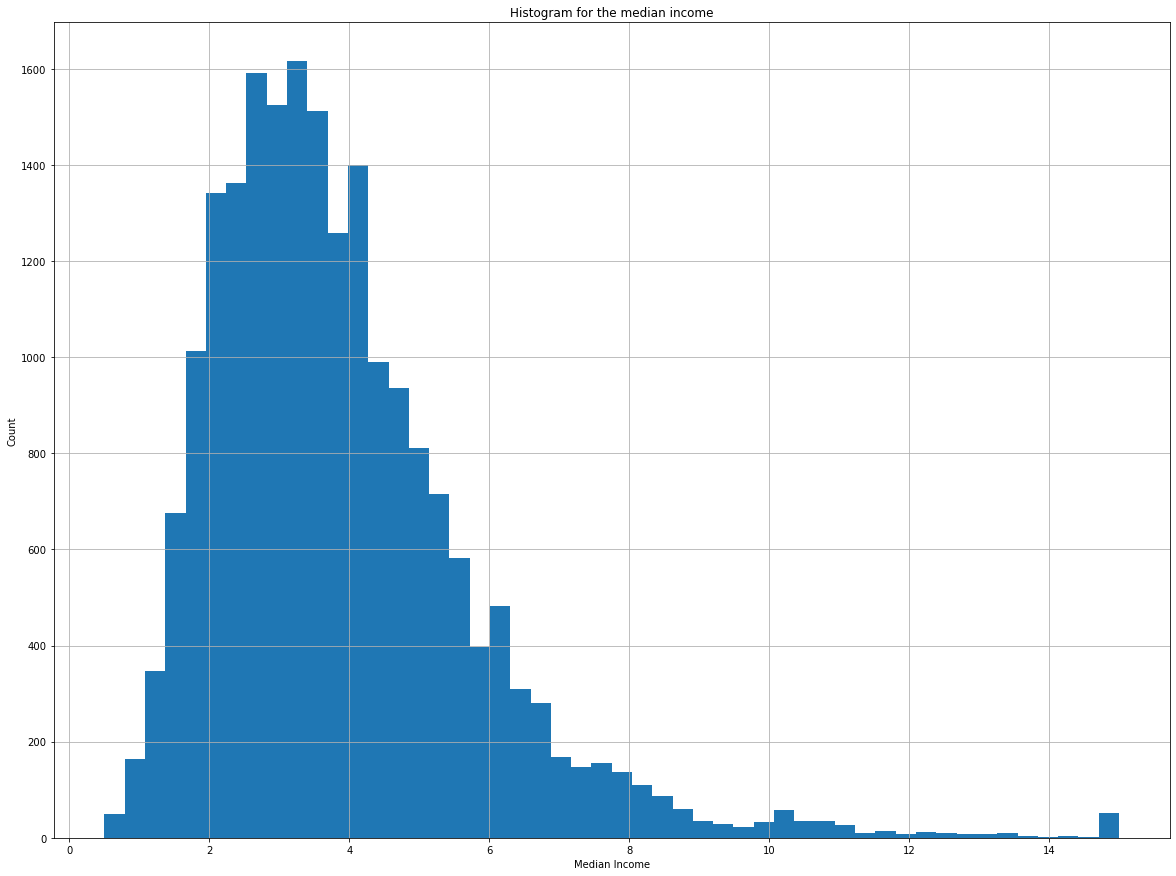

In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

housing['median_income'].hist(bins=50, figsize=(20,15))
plt.xlabel('Median Income')
plt.ylabel('Count')
plt.title('Histogram for the median income')

We can see that most of the median income values are clustered around 2 to 5 (i.e.,$20,000–$50,000), but some median incomes go far beyond 6 (i.e., $60,000). It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum's importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.

The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories) and rounding up using ceil (to have discrete categories), and then keeping only the categories lower than 5 and merging the other categories into category 5:

Text(0.5, 1.0, 'Histogram for the median income')

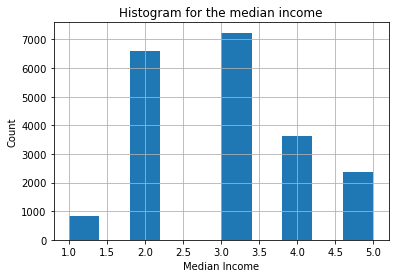

In [23]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()
plt.xlabel('Median Income')
plt.ylabel('Count')
plt.title('Histogram for the median income')

Now you are ready to do stratified sampling based on the income category. For this, we will use Scikit-Learn's **StratifiedShuffleSplit** class:

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's see if this worked as expected. You can start by looking at the income category proportions in the stratified test set and compare it with the proportions in the overall dataset:

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

You can also measure the income category proportions in the full dataset as the following:

In [27]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64